In [1]:
from groq import Groq
from dotenv import load_dotenv
import os
import pandas as pd
from pathlib import Path
from pydantic import BaseModel, ValidationError, conint
from sklearn.metrics import f1_score


In [2]:
# Load environment variables from .env file
load_dotenv()

# Define Pydantic model for response validation
class ClassificationResponse(BaseModel):
    label: conint(strict=True, ge=0, le=1)

In [3]:
# Function to classify text and validate response
def classify_text(text):
    chat_completion = client.chat.completions.create(
        messages=[
            {"role": "system", "content": "You are a classification model that labels text as 1 for stress and 0 for non-stress. You must respond with only a single digit, 1 or 0."},
            {"role": "user", "content": f"Classify the following text as 1 for stress and 0 for non-stress: '{text}'\nLabel:"}
        ],
        max_tokens=1,
        temperature=0,
        model="LLaMA3-70b-8192",
    )
    response = chat_completion.choices[0].message.content.strip()
    try:
        # Validate response using Pydantic
        validated_response = ClassificationResponse(label=int(response))
        return validated_response.label
    except (ValidationError, ValueError):
        # Handle unexpected responses
        return None

In [13]:
# Function to classify text and validate response
def classify_text_enhanced_prompt(text):
    chat_completion = client.chat.completions.create(
        messages=[
            {"role": "system", "content": """
                You are a classification model that labels text as 1 for stress and 0 for non-stress.
                Examples of stress:
                - 'it’s been a terrible struggle the last few years. we have never asked for help from anyone, though. we are hard working and we are proud of our family, and who we are as people. it’s hard to ask for help. but- sometimes we need help too.'
                - 'so my roommate recently moved out and our apartment is pretty empty and ever since she moved out i’ve had the worst anxiety attacks and have been kinda depending on my boyfriend and spending time with him to distract me but he works night and that’s when my anxiety is the absolute worst. everything flutters through my head. like i think i’m annoying him by asking him to spend so much time with me?? (he’s never expressed this. he’s actually expressed the complete opposite which is nice) but i feel like i’m being too clingy and too annoying leading me to want to spend some alone time in my apartment but my apartment just makes me more sad because i’m alone and i feel useless like no one care???'
                Examples of non-stress:
                - 'the few gal friends i associate with are either in relationships or kind of just brush me off or fake like they want to hang out but really don’t when the time comes. my school has no clubs whatsoever, so i can’t really meet anybody that way. i do go to a fairly small school though, around 7,000 students. i always wanted to be in that group that always hangs out. so i honestly don’t know what to do or how to go about this situation.'
                - "i wanted this addressed and my advocate said the next prosecutor taking over my case was great, so don't worry. now in april of this year i got a call from my attorney from the protection order case. my ex's attorney had contacted her to ask why i hadn't dismissed the case like i'd offered originally. he hadn't brought this up in half a dozen trials, and even provided forged documents to prove my ex's innocence. he had finally requested discovery, seen the actual records and asked for dismissal."
                You must respond with only a single digit, 1 or 0.
            """},
            {"role": "user", "content": f"Classify the following text as 1 for stress and 0 for non-stress: '{text}'\nLabel:"}
        ],
        max_tokens=1,
        temperature=0,
        model="LLaMA3-70b-8192",
    )
    response = chat_completion.choices[0].message.content.strip()
    try:
        # Validate response using Pydantic
        validated_response = ClassificationResponse(label=int(response))
        return validated_response.label
    except (ValidationError, ValueError):
        # Handle unexpected responses
        return None

In [4]:
# Initialize Groq client
client = Groq(api_key=os.environ.get("GROQ_API_KEY"))

In [5]:
# Define the path to the data
data_path = Path(os.getcwd()).parent / "data" / "silver"

# Load the dataset
df = pd.read_csv(os.path.join(data_path, 'dreadditCleanTest.csv'))

# Example texts for testing
texts = [
    "hello my name is jake i am 17 years old and i need some help i'll give you a bit of back story ever since i was 5 my mother was always drunk everdently she was an alcoholic and whenever she was drunk she got very agressive and to cut a long story short she abused me for over 8 years not only physically but mentally too and when i was 15 i finally spoke out and went to turn to the authorities but they didn't help they sent me back to my mum countless times and in then end i put myself into care i refused to go back i have been in care for a year and a couple months now but ever since just before chirstmas i've been having these night terrors ( which i have reason to believe that it is ptsd ) i have viscous flash backs of my mother doing all them things too me and i wake up screaming , sweating , and as a instinct ready to fight and it lasts for a good 15 mins which is horrible what i'm trying to get at is , is there any coping mechanisms that you can suggest because i feel useless and helpless at this point",
    "i know what it means to dive into oneself. i asked him and he confirmed its a deeper variant. i got excited. there’s no switching out of consciousness, you can reject what he says, your totally in control (or so he’s telling me :)). so the first part was getting me deep, through counting, dropping my hand and other techniques i went deep."
]

In [6]:
# Classify each text
#for text in texts:
#    label = classify_text(text)
#    print(f"Text: {text}\nLabel: {label}\n")


Text: hello my name is jake i am 17 years old and i need some help i'll give you a bit of back story ever since i was 5 my mother was always drunk everdently she was an alcoholic and whenever she was drunk she got very agressive and to cut a long story short she abused me for over 8 years not only physically but mentally too and when i was 15 i finally spoke out and went to turn to the authorities but they didn't help they sent me back to my mum countless times and in then end i put myself into care i refused to go back i have been in care for a year and a couple months now but ever since just before chirstmas i've been having these night terrors ( which i have reason to believe that it is ptsd ) i have viscous flash backs of my mother doing all them things too me and i wake up screaming , sweating , and as a instinct ready to fight and it lasts for a good 15 mins which is horrible what i'm trying to get at is , is there any coping mechanisms that you can suggest because i feel useless

In [7]:
# Apply classification to the dataframe
df["y_pred"] = df.text.apply(classify_text)

In [15]:
# Apply classification to the dataframe
df["y_pred_enhanced"] = df.text.apply(classify_text_enhanced_prompt)

In [2]:
import pandas as pd
from sklearn.metrics import f1_score, recall_score, precision_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def report_results(y: pd.Series, y_pred: pd.Series):
    fscore = f1_score(y, y_pred, average='binary')
    recall = recall_score(y, y_pred, average='binary')
    precision = precision_score(y, y_pred, average='binary')
    conf_matrix = confusion_matrix(y, y_pred)
    
    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
    plt.xlabel('Predicted Labels')
    plt.ylabel('Actual Labels')
    plt.title('Confusion Matrix')
    plt.show()
    
    return fscore, recall, precision, conf_matrix
    



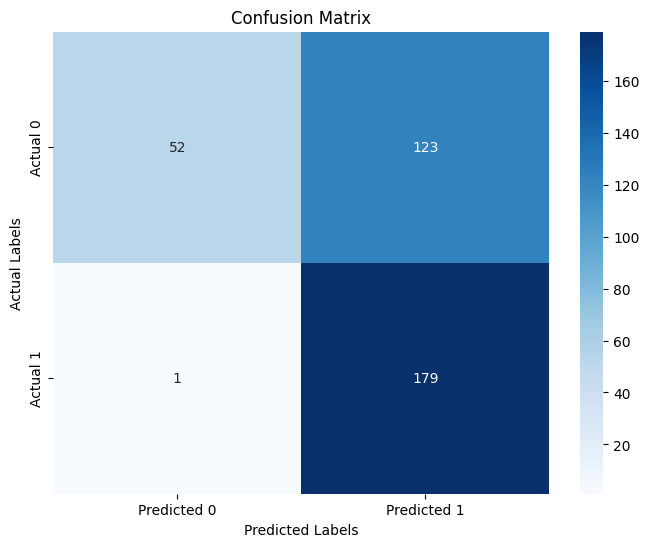

F1 Score: 0.7427385892116183
Recall: 0.9944444444444445
Precision: 0.5927152317880795
Confusion Matrix:
[[ 52 123]
 [  1 179]]


In [17]:
fscore, recall, precision, conf_matrix = report_results(df["label"], df["y_pred"])

print(f"F1 Score: {fscore}")
print(f"Recall: {recall}")
print(f"Precision: {precision}")
print(f"Confusion Matrix:\n{conf_matrix}")

In [3]:
fscore, recall, precision, conf_matrix = report_results(df["label"], df["y_pred_enhanced"])

print(f"F1 Score: {fscore}")
print(f"Recall: {recall}")
print(f"Precision: {precision}")
print(f"Confusion Matrix:\n{conf_matrix}")

NameError: name 'df' is not defined

In [21]:
# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.title(' RoBERTa Confusion Matrix')
plt.show()

label
1    180
0    175
Name: count, dtype: int64